In [2]:
import os
import glob
import ezdxf
from  shapely.geometry import Point
from shapely.geometry.polygon import Polygon,Point
import ezdxf.math as math
from collections import Counter
import matplotlib.pyplot as plt
import  pandas as pd
# pandas version 1.1.3
import geopandas
import numpy as np
import time
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

In [3]:
pbar = ProgressBar()
pbar.register()

In [4]:
BASE_DIR = "D:\VR3D\VR3D_DATASET"

In [5]:
def  dxf_to_geopandas(dxf_file,ind_dxf):
    #doc = ezdxf.readfile(dxf_file[0][ind_dxf])
    doc = ezdxf.readfile(dxf_file)
    #doc = ezdxf.readfile("D:\VR3D\VR3D_DATASET\J35_txt_cutted\VR3D_paris\Download\PARIS_ASS_Z8.dxf")

    #print(dxf_file[0][ind_dxf])
    msp = doc.modelspace()
    lwschema = msp.query('LWPOLYLINE')
    
    polys1 = geopandas.GeoSeries()
    pol = []
    Rayon = []
    Z_eleva = []
    for pline in lwschema :
        Z_eleva.append(pline.dxf.elevation)
        if not pline.has_arc:
            poly = []
            ma_x = []
            ma_y = []
            for p in range(len(pline)):
                x,y,s,e,b = pline[p]
                ma_x.append(x)
                ma_y.append(y)
                poly.append((x,y))
            pol.append([min(ma_x),min(ma_y),max(ma_x),max(ma_y)])
            #pol.append(poly)
            #poly[0] = (poly[0][0]+10.00000,poly[0][1])
            polys1 = polys1.append(geopandas.GeoSeries([Polygon(poly)]),ignore_index = True)
        else :
            polygon_data = {}
            bulg = []
            cx = []
            cy = []
            radius = []
            nxt = 0

            for pl in range(len(pline)):
                x, y, s, e, b = pline[pl]
                bulg.append(b)
                polygon_data[pl] = [x, y]

                if nxt > 0 :
                    C = math.bulge_center(polygon_data[nxt-1],polygon_data[nxt],bulg[nxt-1])
                    cx.append(C[0])
                    cy.append(C[1])
                    R = math.bulge_radius(polygon_data[nxt - 1], polygon_data[nxt], bulg[nxt - 1])
                    radius.append(R)

                if pl+1 == len(pline) :
                    centerX = np.mean(cx)
                    centerY = np.mean(cy)
                    cercleR = np.mean(radius)
                    Rayon.append(cercleR)
                    #AllCercle.append([centerX,centerY,cercleR])
                    cx = []
                    cy = []
                    radius = []
                nxt += 1
            pol.append([centerX - cercleR,centerY - cercleR,centerX + cercleR,centerY + cercleR])
            polys1 = polys1.append(geopandas.GeoSeries([Point(centerX,centerY).buffer(cercleR)]),ignore_index = True)
    return pol,polys1,Z_eleva
        

In [6]:
def run(dxf_file):
    pg = pd.DataFrame()
    poly_geopandas = geopandas.GeoSeries()
    Z_eleva = pd.DataFrame()
    for i in range(1):
        pgs,polys_geopandas,Z_ele = dxf_to_geopandas(dxf_file,i)
        if len(polys_geopandas) == 1:
            pass
        else :
            pg = pg.append(pgs[:],ignore_index=True)
            poly_geopandas = poly_geopandas.append(polys_geopandas[:],ignore_index = True)
            Z_eleva = Z_eleva.append(Z_ele[:],ignore_index=True)
    return pg,poly_geopandas,Z_eleva

Pour Le Gros Data

In [7]:
def cherche_dask(i,ddf,pg):
    #ddf = ddf.rename(columns={0:'X',1:'Y',2:'Z',3:'I'})
    ddf['L'] = 0
    df1 = ddf[(ddf.X >= pg[0][i])&(ddf.X <= pg[2][i])&(ddf.Y >= pg[1][i])&(ddf.Y <= pg[3][i])]
    return df1

In [8]:
def create_fichier_list(poly_geopandas,ind_zone,Name,Name_reseau):
    '''
    Name :'Paris','Bordeau',...
    Name_reseau : 'ASS','TELECOM',...
    ind_zone : 1,2,3,...
    '''
    fichier_list = []
    for i in range(len(poly_geopandas)):
        # _path = "D:\VR3D\VR3D_DATASET\Out_chambre\Paris\\Paris_Z1\\ASS"
        _path = BASE_DIR+'\Out_chambre\\'+Name+'\\'+Name+'_Z'+str(ind_zone+1)
        if os.path.exists(_path):
            if os.path.exists(_path+'\\'+Name_reseau):
                fichier_list.append(_path+'\\'+Name_reseau+
                            '\\Nuage_points_'+str(i)+'.txt')
            else :
                os.mkdir(_path+'\\'+Name_reseau)
                fichier_list.append(_path+'\\'+Name_reseau+
                            '\\Nuage_points_'+str(i)+'.txt')
        else :
            os.mkdir(_path)
            os.mkdir(_path+'\\'+Name_reseau)
            fichier_list.append(_path+'\\'+Name_reseau+'\\Nuage_points_'+str(i)+'.txt')
    return  fichier_list

In [9]:
def train(couple,poly_geopandas,path_dxf,ind_zone,Name,Name_reseau):
    for i in range(len(couple)):
        df = pd.DataFrame(poly_geopandas.contains(Point(couple.loc[i][0],couple.loc[i][1])))
        index = df.index
        condition = df[0] == True
        ind = index[condition]
        if not ind.empty:
            couple['L'][i] = 1
            fichier_list = create_fichier_list(poly_geopandas,ind_zone,Name,Name_reseau)
            fichier = open(fichier_list[ind[0]],'a')
            fichier.write(str(couple.loc[i][0])+' '+str(couple.loc[i][1])+' '
                      +str(couple.loc[i][2])+' '+str(couple.loc[i][3])+' '+str(couple.loc[i][4])+'\n')
            fichier.close()
            
    return couple

In [10]:
'''def final_train():
    for i in range(218):
        chre = cherche_dask(i)
        data_final = chre.compute()
        data_final = data_final.reset_index(drop = True)
        train(data_final)
        print('--------------------',i,'-----------------')
 '''   

"def final_train():\n    for i in range(218):\n        chre = cherche_dask(i)\n        data_final = chre.compute()\n        data_final = data_final.reset_index(drop = True)\n        train(data_final)\n        print('--------------------',i,'-----------------')\n "

In [31]:
def final_train_sans_dask(pg,poly_geopandas,path_dxf,ind_zone,Name,Name_reseau):
    #fil_list = pd.read_csv(
    fil_list = pd.read_csv(BASE_DIR+'\Out_nuage\Down_sample\Down_sample_'+
                           Name+'_0.5\List_file.txt')
    print(len(fil_list))
    #for j in range(len(fil_list)):
    ddf = pd.read_csv(fil_list['0'][ind_zone])
    #ddf['L'] = 0
    for i in range(len(pg)):#116#nbr de chambre
        data_final = cherche_dask(i,ddf,pg)
        data_final = data_final.reset_index(drop = True)
        train(data_final,poly_geopandas,path_dxf,ind_zone,Name,Name_reseau)
        print('--------------------',i,ind_zone,'-----------------')
        

Ecrire tous les fichiers dxf par zone dans un fichier

In [11]:
def create_list_zone(Name):
    _path = BASE_DIR+'\J35_txt_cutted\\VR3D_'+Name+'\\DXF_file'
    os.chdir(_path)
    fichier = open(_path+'\\List_file.txt','w')
    for file in glob.glob('*'):
        if '.txt' in file:
            pass
        else :
            fichier.write(_path+'\\'+file+'\n')
    fichier.close()

In [12]:
def create_list_reseau(Name,ind_zone,shp):
    for i in range(shp):
        _path = BASE_DIR+'\J35_txt_cutted\\VR3D_'+Name+'\\DXF_file\Z'+str(ind_zone+1)
        os.chdir(_path)
        fichier = open(_path+'\\List_file.txt','w')
        for file in glob.glob("*"):
            if '.txt' in file:
                pass
            else : 
                fichier.write(_path+'\\'+file+'\n')
        fichier.close()

In [26]:
def run_final(Name):
    create_list_zone(Name)
    shp = len(pd.read_csv(BASE_DIR+'\J35_txt_cutted\\VR3D_'+Name+'\\DXF_file\\List_file.txt',header=None))
    for j in range(shp): # j : Zone
        create_list_reseau(Name,j,shp)
        R_path = pd.read_csv(BASE_DIR+'\J35_txt_cutted\\VR3D_'+
                             Name+'\\DXF_file\Z'+str(j+1)+'\\List_file.txt',header=None)
        
        for i in range(len(R_path)): # i :Reseau
            _path = R_path[0][i]
            os.chdir(_path)    
            for file in glob.glob("*.dxf"):
                dxf_file = _path+'\\'+file
            print(dxf_file)
            pg,poly_geopandas,Z_eleva = run(dxf_file)
            print(len(pg),'len')
            pg.to_csv(_path+'\\Max_Min_chambre.txt',index = False)
            poly_geopandas.to_csv(_path+'\\Pd_Geopandas_chambre.txt',index = False)
            Z_eleva.to_csv(_path+'\\Z_elevation.txt',index = False)
            final_train_sans_dask(pg,poly_geopandas,_path,j,Name,R_path[0][i].split('\\')[-1])#59 : ??????????
            print(f'----------Le reseau n:{i} de zone n : {j} est balaye----------')

In [33]:
run_final('XX')

D:\VR3D\VR3D_DATASET\J35_txt_cutted\VR3D_XX\DXF_file\Z1\ASS\PUY-DE-DOME_ASS_1-11.dxf
59 len
1


C:\Users\A2921~1.RAK\AppData\Local\Temp/ipykernel_24352/3114565400.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  couple['L'][i] = 1


-------------------- 0 0 -----------------
-------------------- 1 0 -----------------
-------------------- 2 0 -----------------
-------------------- 3 0 -----------------
-------------------- 4 0 -----------------
-------------------- 5 0 -----------------
-------------------- 6 0 -----------------
-------------------- 7 0 -----------------
-------------------- 8 0 -----------------
-------------------- 9 0 -----------------
-------------------- 10 0 -----------------
-------------------- 11 0 -----------------
-------------------- 12 0 -----------------
-------------------- 13 0 -----------------
-------------------- 14 0 -----------------
-------------------- 15 0 -----------------
-------------------- 16 0 -----------------
-------------------- 17 0 -----------------
-------------------- 18 0 -----------------
-------------------- 19 0 -----------------
-------------------- 20 0 -----------------
-------------------- 21 0 -----------------
-------------------- 22 0 ----------------

In [158]:
'''for i in range(len(Zone_list)):
    path_dxf = Zone_list[0][i]
    dxf_file = pd.read_csv(path_dxf+'\\Dxf_file.txt',header = None)
    pg,poly_geopandas,Z_eleva = run(dxf_file)
    pg.to_csv(path_dxf+'\\Max_Min_chambre.txt',index = False)
    poly_geopandas.to_csv(path_dxf+'\\Pd_Geopandas_chambre.txt',index = False)
    Z_eleva.to_csv(path_dxf+'\\Z_elevation.txt',index = False)
    #final_train_sans_dask(pg,poly_geopandas,path_dxf,i)# reste commenter cette ligne si le phase de donne_sampling n'est encore fini
    print(f'-----Zone n:{i+1}------------')'''

"for i in range(len(Zone_list)):\n    path_dxf = Zone_list[0][i]\n    dxf_file = pd.read_csv(path_dxf+'\\Dxf_file.txt',header = None)\n    pg,poly_geopandas,Z_eleva = run(dxf_file)\n    pg.to_csv(path_dxf+'\\Max_Min_chambre.txt',index = False)\n    poly_geopandas.to_csv(path_dxf+'\\Pd_Geopandas_chambre.txt',index = False)\n    Z_eleva.to_csv(path_dxf+'\\Z_elevation.txt',index = False)\n    #final_train_sans_dask(pg,poly_geopandas,path_dxf,i)# reste commenter cette ligne si le phase de donne_sampling n'est encore fini\n    print(f'-----Zone n:{i+1}------------')"

Faire de filtrage en utilisant Z_elevation


In [34]:
def initialise_stat(fil_list,Z_eleva):
    
    stat_descr = fil_list.copy()
    stat_descr = stat_descr.rename({0:'Name_chambre'},axis=1)
    Min_chambr = []
    Z_elevation = []
    Max_chambr = []
    shp = len(fil_list[0][0]) - 5
    for i in range(len(fil_list)):
        Min_chambr.append(pd.read_csv(fil_list[0][i],header=None,sep=' ')[2].min())
        Max_chambr.append(pd.read_csv(fil_list[0][i],header=None,sep=' ')[2].max())
        Z_elevation.append(Z_eleva['0'][int(fil_list[0][i][shp:][:-4])])#56 ou 53
            
    stat_descr['Min/chambr'] = Min_chambr
    stat_descr['Z_elevation'] = Z_elevation
    stat_descr['Max/chambr'] = Max_chambr
    stat_descr['Diff_MIn'] = stat_descr['Min/chambr'] - stat_descr['Z_elevation']
    stat_descr['Diff_Max'] = stat_descr['Max/chambr'] - stat_descr['Z_elevation']
    return stat_descr

In [35]:
def get_filtre(stat_descr):
    stat_descr['Z_filter_Mean'] = stat_descr.Z_elevation + stat_descr.Diff_MIn.median()#Utilisation Min.mean
    alpha_coeff = stat_descr[stat_descr['Max/chambr'] == stat_descr['Max/chambr'].min()]
    alpha_index = alpha_coeff.index[0]
    alpha_coeff = alpha_coeff.Diff_Max[alpha_index]
    stat_descr['Z_filter_Max_Min'] = stat_descr.Z_elevation + alpha_coeff#Utilisation Max_Min
    return stat_descr

Filtrage & Ecriture de fichier final

Approche Troitoir & route--------------------

In [36]:
'''def Isolation(stat_descr,name_filter): 
    Isolatio = pd.DataFrame()
    Name_ch = []
    for i in range(len(stat_descr)):
        chmbr = pd.read_csv(stat_descr.Name_chambre.loc[i],header=None,sep=' ')
        chmbr = chmbr[chmbr[2] <= stat_descr.Z_filter_Max_Min[i]]
        if len(chmbr) >= 2:
            print(stat_descr.Name_chambre.loc[i])
            chmbr.to_csv(stat_descr.Name_chambre.loc[i][:-4]+name_filter+'.txt',index=False)
            Name_ch.append(stat_descr.Name_chambre.loc[i][:-4]+name_filter+'.txt')
    return Name_ch'''

"def Isolation(stat_descr,name_filter): \n    Isolatio = pd.DataFrame()\n    Name_ch = []\n    for i in range(len(stat_descr)):\n        chmbr = pd.read_csv(stat_descr.Name_chambre.loc[i],header=None,sep=' ')\n        chmbr = chmbr[chmbr[2] <= stat_descr.Z_filter_Max_Min[i]]\n        if len(chmbr) >= 2:\n            print(stat_descr.Name_chambre.loc[i])\n            chmbr.to_csv(stat_descr.Name_chambre.loc[i][:-4]+name_filter+'.txt',index=False)\n            Name_ch.append(stat_descr.Name_chambre.loc[i][:-4]+name_filter+'.txt')\n    return Name_ch"

In [37]:
#name_filter = ['route','trotoir'] #filtrage sur la route et filtrage aux trotoir

In [38]:
'''Name_ch = pd.DataFrame()
for i in range(len(name_filtre)):
    stat_descr = get_filtre(stat_descr)
    Name_ch = Name_ch.append(Isolation(stat_descr,name_filtre[i]))
    stat_descr = stat_descr[stat_descr['Min/chambr']>stat_descr.Z_filter_Max_Min]
    stat_descr = stat_descr.reset_index(drop=True)
Name_ch.to_csv(stat_descr.Name_chambre.loc[0][:40]+'Fil_list_filtre2.txt',index=False)'''

"Name_ch = pd.DataFrame()\nfor i in range(len(name_filtre)):\n    stat_descr = get_filtre(stat_descr)\n    Name_ch = Name_ch.append(Isolation(stat_descr,name_filtre[i]))\n    stat_descr = stat_descr[stat_descr['Min/chambr']>stat_descr.Z_filter_Max_Min]\n    stat_descr = stat_descr.reset_index(drop=True)\nName_ch.to_csv(stat_descr.Name_chambre.loc[0][:40]+'Fil_list_filtre2.txt',index=False)"

---------------------------------------------

Approche Mean

In [39]:
def Isolation(stat_descr): 
    Name_ch = []
    for i in range(len(stat_descr)):
        chmbr = pd.read_csv(stat_descr.Name_chambre.loc[i],header=None,sep=' ')
        chmbr = chmbr[chmbr[2] <= stat_descr.Z_filter_Mean[i]+0.1]
        if len(chmbr) >= 2:
            print(stat_descr.Name_chambre.loc[i])
            print(stat_descr.Name_chambre.loc[i][:-4]+'filter.txt')
            chmbr.to_csv(stat_descr.Name_chambre.loc[i][:-4]+'filter.txt',index=False)
            Name_ch.append([stat_descr.Name_chambre.loc[i][:-4]+'filter.txt'])
    #pd.DataFrame(Name_ch).to_csv(stat_descr.Name_chambre.loc[0][:40]+'Fil_list_filtre.txt',index=False)
    

In [40]:
def create_list_reseau(Name,ind_zone):
    _path = BASE_DIR+'\Out_chambre\\'+Name+'\\'+Name+'_Z'+str(ind_zone+1)
    os.chdir(_path)
    fichier = open(_path+'\\List_file.txt','w')
    for file in glob.glob('*'):
        if '.txt' in file:
            pass
        else :
            fichier.write(_path+'\\'+file+'\n')
    fichier.close()

In [41]:
def create_list_chambre(Name,ind_zone):
    _path = BASE_DIR+'\Out_chambre\\'+Name+'\\'+Name+'_Z'+str(ind_zone+1)
    x_temp = pd.read_csv(_path+'\\List_file.txt',header=None)
    for i in range(len(x_temp)):
        os.chdir(x_temp[0][i])
        fichier = open(x_temp[0][i]+'\\List_file.txt','w')
        for file in glob.glob('N*.txt'):
            fichier.write(x_temp[0][i]+'\\'+file+'\n')
        fichier.close()

In [45]:
def run_stat(Name):
    for i in range(1):#  8 :nombre de zone a travaille
        # creation de list_reseau et list_chambre
        create_list_reseau(Name,i)
        create_list_chambre(Name,i)
        
        List_Reseau = pd.read_csv(BASE_DIR+'\Out_chambre\\'
                                  +Name+'\\'+Name+'_Z'+str(i+1)+'\List_file.txt',header = None)
        List_Rdxf = pd.read_csv(BASE_DIR+'\J35_txt_cutted\\VR3D_'
                                +Name+'\\DXF_file\\Z'+str(i+1)+'\List_file.txt',header=None)
        
        for j in range(len(List_Reseau)):# j : Nombre de Reseau pour chaque Zone 
            # list de chambre par reseau pour chaque Zone
            fil_list = pd.read_csv(List_Reseau[0][j]+"\List_file.txt",header=None)
            Z_eleva = pd.read_csv(List_Rdxf[0][j]+"\Z_elevation.txt")
            stat_descr = initialise_stat(fil_list,Z_eleva)
        
            #Enregistrement de la statistique du model 
            pd.DataFrame(stat_descr.Diff_MIn.describe()).to_csv(List_Reseau[0][j]+'\\stat_files.txt')
        
            # Filtrage de chaque chambre 
            stat_descr = get_filtre(stat_descr)
            Isolation(stat_descr)
            print(f'Filtrage chambre du reseau n:{j} de la zone n:{i} est fini')

In [49]:
for i in range(1):
    print(i)

0


In [46]:
run_stat('XX')

KeyError: 2

<AxesSubplot:>

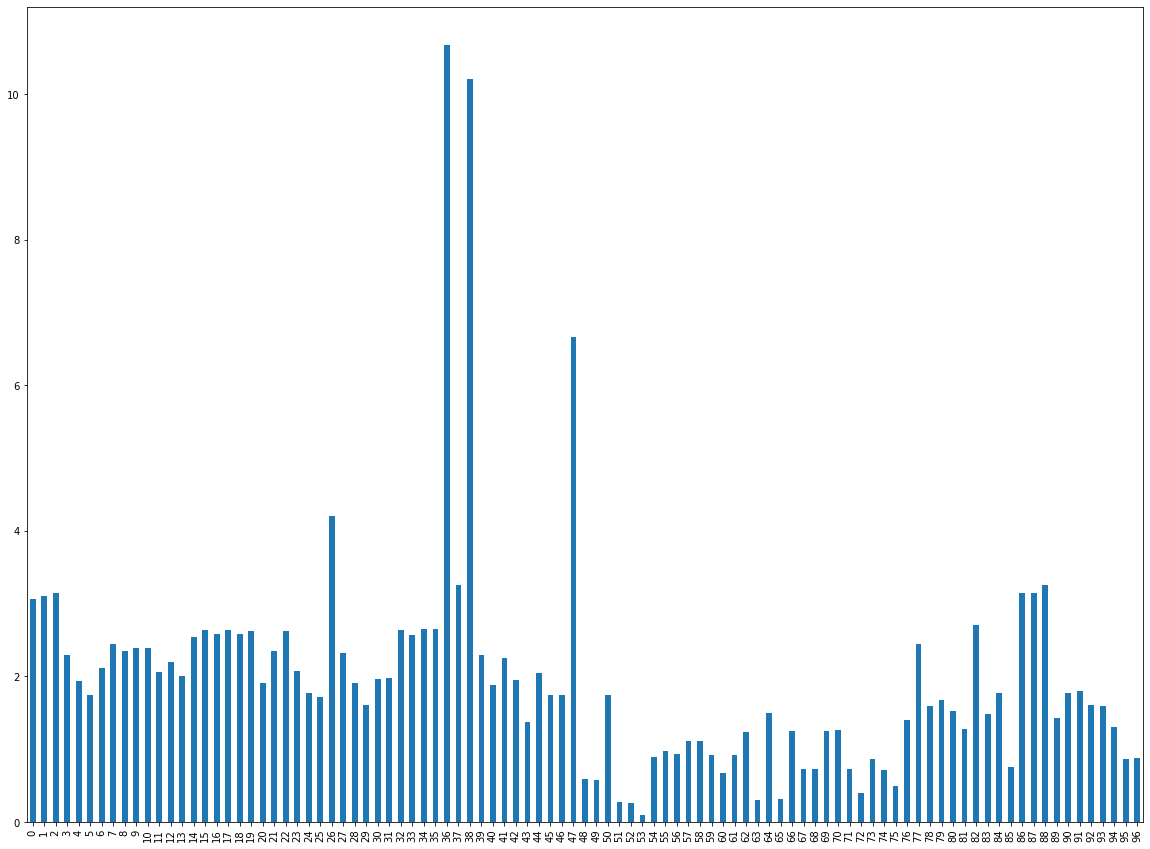

In [114]:
plt.figure(figsize=(20,15))
stat_descr.Diff_MIn.plot.bar()

<AxesSubplot:>

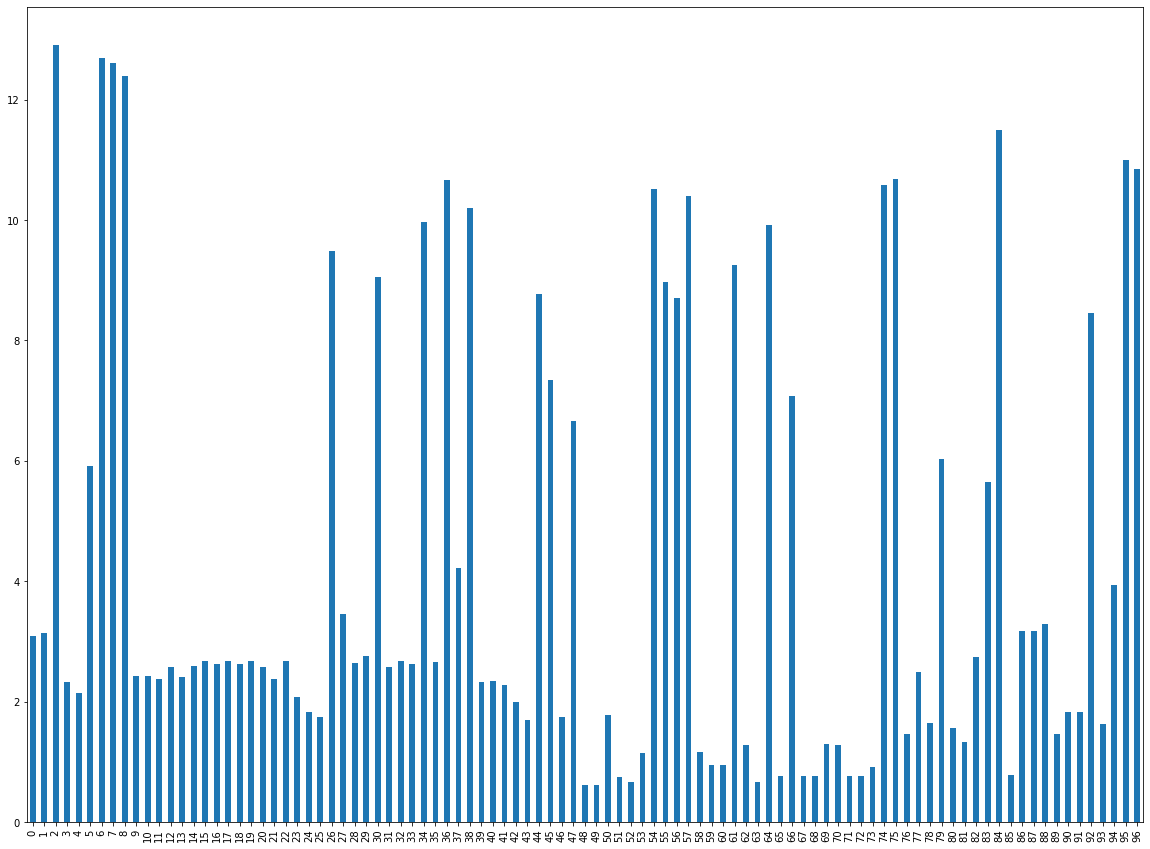

In [115]:
plt.figure(figsize=(20,15))
stat_descr.Diff_Max.plot.bar()

In [116]:
stat_descr.Diff_MIn.describe()

count    97.000000
mean      1.981072
std       1.567285
min       0.100000
25%       1.117752
50%       1.770000
75%       2.438875
max      10.667000
Name: Diff_MIn, dtype: float64

Recherche §_filtre